In [1]:
print("hello world")

hello world


In [2]:
# importing the necessary library that will require for this project , the project we are working on


import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")

In [5]:
# now its time to load the datasets and see what insights our data holds
df = pd.read_csv("/content/Walmart Data Analysis and Forcasting.csv")
df.head()


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [6]:
# checking the info of data
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
# understanding the statistics of the data
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [10]:
# convert date column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
df = df.sort_values('Date')

In [11]:
# lets its time to perform data preprocessing
df.isnull().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [12]:
# Aggregate sales (important for forecasting)
daily_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
daily_sales.set_index('Date', inplace=True)


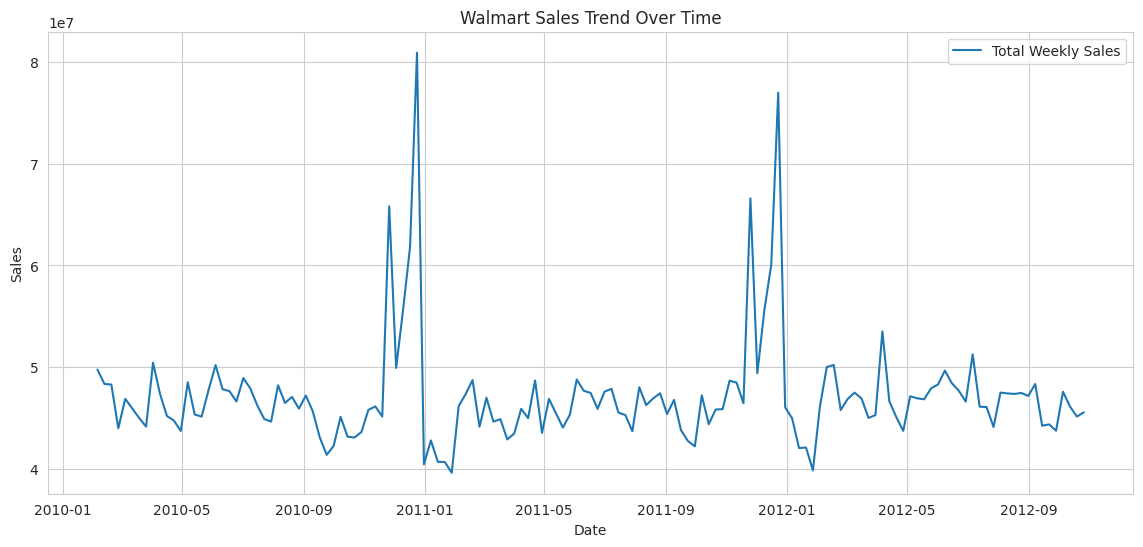

In [13]:
# after performing preprocessing let do EDA
# sales overtime
plt.figure(figsize=(14,6))
plt.plot(daily_sales, label="Total Weekly Sales")
plt.title("Walmart Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()



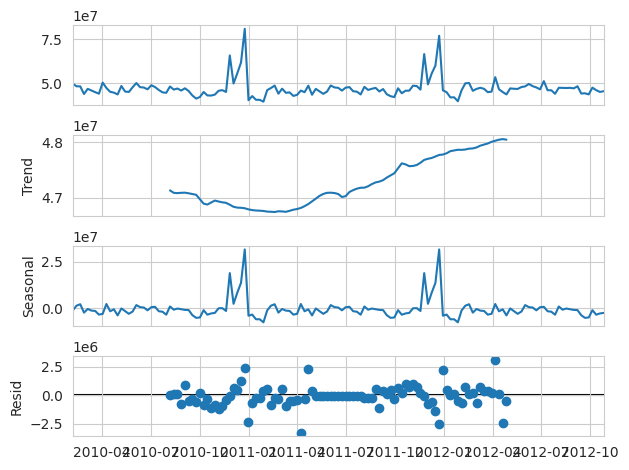

In [14]:
# lets understand seasonality decomposition'
decomposition = seasonal_decompose(daily_sales, model='additive', period=52)
decomposition.plot()
plt.show()


In [16]:
# traint test split time series correct way
train_size = int(len(daily_sales) * 0.8)
train = daily_sales.iloc[:train_size]
test = daily_sales.iloc[train_size:]


In [17]:
# Sales Forecasting (SARIMA – Industry Preferred)
model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit()
print(model_fit.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  114
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -112.408
Date:                            Mon, 29 Dec 2025   AIC                            234.817
Time:                                    05:50:40   BIC                            234.546
Sample:                                02-05-2010   HQIC                           231.474
                                     - 04-06-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4030      7.107     -0.057      0.955     -14.333      13.527
ma.L1         -0.9235      3.787   

In [18]:
# Forecasting & Evaluation
forecast = model_fit.predict(
    start=test.index[0],
    end=test.index[-1],
    dynamic=False
)

mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 1703732.8276520711
RMSE: 2129750.4191892785


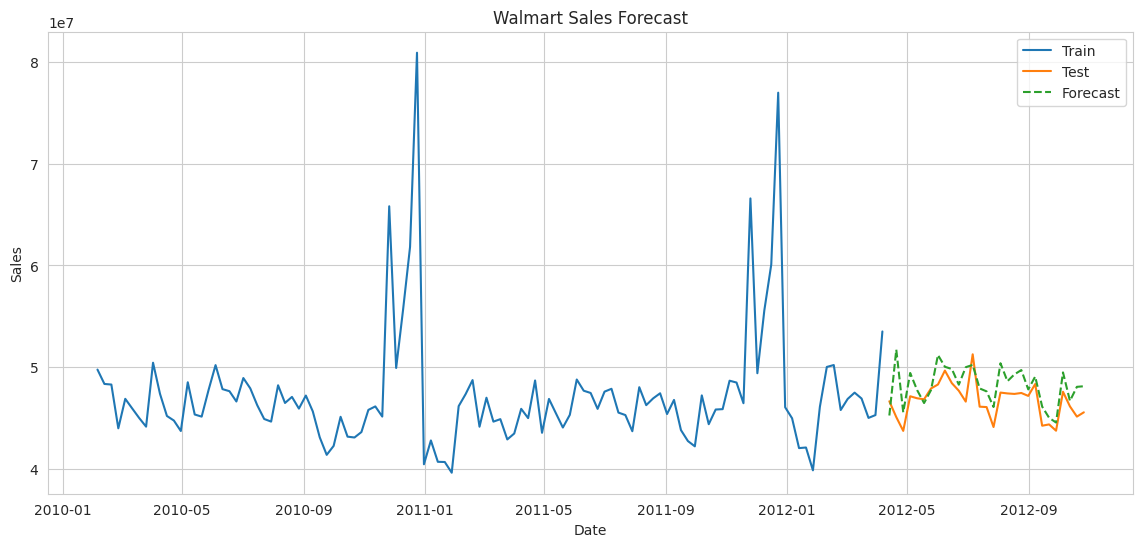

In [19]:
# Forecast Visualization
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(forecast, label='Forecast', linestyle='--')
plt.title("Walmart Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [22]:
# Forecast Future Sales (Next 12 Weeks)
import os

future_forecast = model_fit.forecast(steps=12)

future_dates = pd.date_range(
    start=daily_sales.index[-1],
    periods=13,
    freq='W'
)[1:]

future_df = pd.DataFrame({
    'Date': future_dates,
    'Forecasted_Sales': future_forecast.values
})

# Create the 'results' directory if it doesn't exist
os.makedirs('results', exist_ok=True)

future_df.to_csv("results/forecasts.csv", index=False)
future_df

,Date,Forecasted_Sales
0,2012-11-04,4.523059e+07
1,2012-11-11,5.170981e+07
2,2012-11-18,4.554071e+07
3,2012-11-25,4.941670e+07
4,2012-12-02,4.773297e+07
5,2012-12-09,4.645841e+07
6,2012-12-16,4.773380e+07
7,2012-12-23,5.118666e+07
8,2012-12-30,5.002519e+07
9,2013-01-06,4.980545e+07
